# Main imports and code

In [1]:
from urllib import request
import pandas as pd
import logging
import torch
from collections import Counter
from ast import literal_eval

import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import random
import re
import importlib

from transformers import AutoModel, AutoTokenizer
from tqdm import tqdm

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
import os

os.chdir('/content/drive/MyDrive/NLP_Coursework/')
print(f"Current working directory: {os.getcwd()}")

Current working directory: /content/drive/MyDrive/NLP_Coursework


In [4]:
# prepare logger
logging.basicConfig(level=logging.INFO)

transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

# check gpu
cuda_available = torch.cuda.is_available()

print('Cuda available? ',cuda_available)

Cuda available?  True


# Fetch Don't Patronize Me! data manager module

In [5]:
# helper function to save predictions to an output file
def labels2file(p, outf_path):
	with open(outf_path,'w') as outf:
		for pi in p:
			outf.write(','.join([str(k) for k in pi])+'\n')

In [6]:
from dont_patronize_me import DontPatronizeMe

In [7]:
dpm = DontPatronizeMe('.', '.')

In [8]:
dpm.load_task1()
dpm.load_task2(return_one_hot=True)

Map of label to numerical label:
{'Unbalanced_power_relations': 0, 'Shallow_solution': 1, 'Presupposition': 2, 'Authority_voice': 3, 'Metaphors': 4, 'Compassion': 5, 'The_poorer_the_merrier': 6}


# Load paragraph IDs

In [9]:
trids = pd.read_csv('data/train_semeval_parids-labels.csv')
teids = pd.read_csv('data/dev_semeval_parids-labels.csv')

In [10]:
trids.par_id = trids.par_id.astype(str)
teids.par_id = teids.par_id.astype(str)

In [11]:
data=dpm.train_task1_df

In [12]:
data

,par_id,art_id,keyword,country,text,label,orig_label
0,1,@@24942188,hopeless,ph,"We 're living in times of absolute insanity , ...",0,0
1,2,@@21968160,migrant,gh,"In Libya today , there are countless number of...",0,0
2,3,@@16584954,immigrant,ie,"""White House press secretary Sean Spicer said ...",0,0
3,4,@@7811231,disabled,nz,Council customers only signs would be displaye...,0,0
4,5,@@1494111,refugee,ca,""""""" Just like we received migrants fleeing El ...",0,0
...,...,...,...,...,...,...,...
10464,10465,@@14297363,women,lk,"""Sri Lankan norms and culture inhibit women fr...",0,1
10465,10466,@@70091353,vulnerable,ph,He added that the AFP will continue to bank on...,0,0
10466,10467,@@20282330,in-need,ng,""""""" She has one huge platform , and informatio...",1,3
10467,10468,@@16753236,hopeless,in,""""""" Anja Ringgren Loven I ca n't find a word t...",1,4




# Rebuild training set (Task 1)

In [14]:
rows = []

# speed up lookups by indexing once
data_indexed = data.set_index("par_id")
trids_indexed = trids.set_index("par_id")

for parid in trids_indexed.index:

    # From original data (binary + metadata)
    row_data = data_indexed.loc[parid]
    text = row_data.text
    pcl_label = row_data.label
    community = row_data.keyword

    # From task2 (multi-label categories)
    category_labels = trids_indexed.loc[parid].label
    label = literal_eval(category_labels) + [pcl_label]

    rows.append({
        "par_id": parid,
        "community": community,
        "text": text,
        "label": label
    })

In [15]:
trdf1 = pd.DataFrame(rows)

In [16]:
trdf1

,par_id,community,text,label
0,4341,poor-families,"The scheme saw an estimated 150,000 children f...","[1, 0, 0, 1, 0, 0, 0, 1]"
1,4136,homeless,Durban 's homeless communities reconciliation ...,"[0, 1, 0, 0, 0, 0, 0, 1]"
2,10352,poor-families,The next immediate problem that cropped up was...,"[1, 0, 0, 0, 0, 1, 0, 1]"
3,8279,vulnerable,Far more important than the implications for t...,"[0, 0, 0, 1, 0, 0, 0, 1]"
4,1164,poor-families,To strengthen child-sensitive social protectio...,"[1, 0, 0, 1, 1, 1, 0, 1]"
...,...,...,...,...
8370,8380,refugee,Rescue teams search for survivors on the rubbl...,"[0, 0, 0, 0, 0, 0, 0, 0]"
8371,8381,hopeless,The launch of ' Happy Birthday ' took place la...,"[0, 0, 0, 0, 0, 0, 0, 0]"
8372,8382,homeless,"The unrest has left at least 20,000 people dea...","[0, 0, 0, 0, 0, 0, 0, 0]"
8373,8383,hopeless,You have to see it from my perspective . I may...,"[0, 0, 0, 0, 0, 0, 0, 0]"


In [17]:
roberta = AutoModel.from_pretrained("roberta-base").to('cuda')
tokenizer = AutoTokenizer.from_pretrained("roberta-base")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading weights:   0%|          | 0/197 [00:00<?, ?it/s]

RobertaModel LOAD REPORT from: roberta-base
Key                             | Status     | 
--------------------------------+------------+-
lm_head.layer_norm.bias         | UNEXPECTED | 
lm_head.dense.bias              | UNEXPECTED | 
roberta.embeddings.position_ids | UNEXPECTED | 
lm_head.dense.weight            | UNEXPECTED | 
lm_head.bias                    | UNEXPECTED | 
lm_head.layer_norm.weight       | UNEXPECTED | 
pooler.dense.bias               | MISSING    | 
pooler.dense.weight             | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


In [51]:
embs = []
for text in tqdm(trdf1.text):
  inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to('cuda')
  outputs = roberta(**inputs)
  embs.append(outputs.last_hidden_state.mean(dim=1).detach().cpu().numpy().squeeze())

labels = [label[-1] for label in trdf1.label]

100%|██████████| 8364/8364 [01:52<00:00, 74.04it/s]


In [52]:
X = np.array(embs)
y = np.array(labels)

tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X)

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


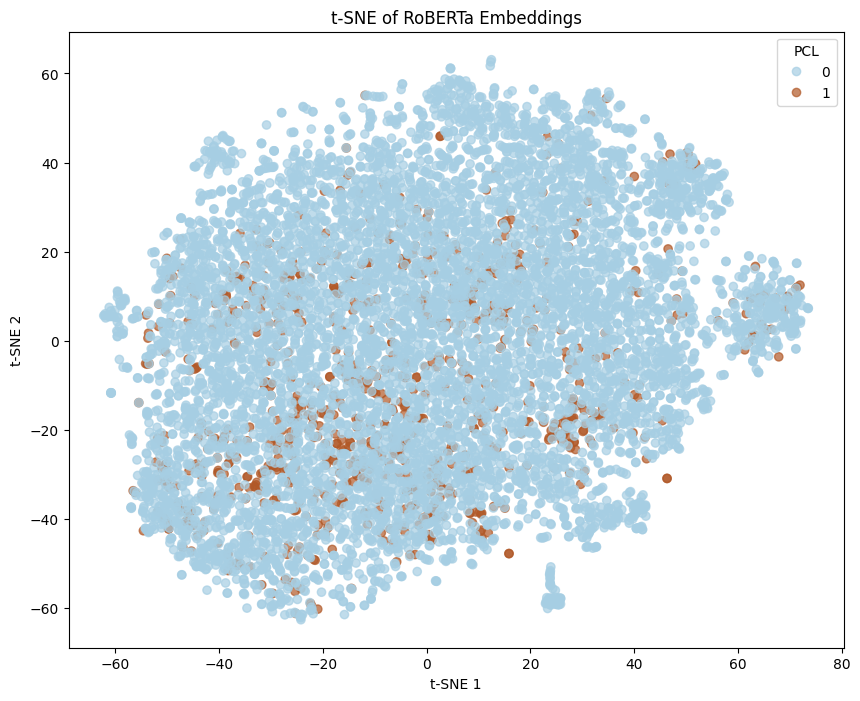

In [53]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_tsne[:,0], X_tsne[:,1], c=y, cmap='Paired', alpha=0.7)
plt.legend(*scatter.legend_elements(), title="PCL")
plt.title("t-SNE of RoBERTa Embeddings")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.show()

In [19]:
# Iterate through each row of the dataframe
for idx, text in enumerate(trdf1['text'][:500]):
    # Find all non-alphanumeric characters (excluding spaces)
    special_chars = re.findall(r'[^a-zA-Z0-9\s\",\' \.\-?\(\):;!\$\&#/%]', text)
    if special_chars:
        print(f"Row {idx}: {special_chars} {text}")

Row 12: ['<', '>'] Together with wife Vicky , Cornell established the Chris &amp; Vicky Cornell Foundation , a charity that works with vulnerable children . The charity currently focuses on protecting these children from the ravages of homelessness , poverty , abuse and neglect . <h> 7 . Cuba concert
Row 18: ['<', '>'] Even though many of these students get selected to subordinate services , the service is capable of uplifting their poor families . <h> Impact
Row 46: ['*'] For 12 years Ruby* lived a life of abuse , drugs , homelessness and prostitution . But two months ago she joined the lucky few to escape the horrors of prostitution .
Row 84: ['<', '>'] A Cruel And Violent Political Strategy <h> Asylum seekers on Manus Island and Nauru have been exiled , displaced , crushed and left hopeless .
Row 104: ['<', '>'] Mother of three on the brink of being homeless again <h> by
Row 119: ['<', '>'] "This raises the question about the network of religious "" madrassa "" education , where chi

In [20]:
trdf1['text'] = trdf1['text'].str.replace(r"<[^>]+>|\*|@", "", regex=True)

In [21]:
import re

# Iterate through each row of the dataframe
for idx, text in enumerate(trdf1['text']):
    # Find all non-alphanumeric characters (excluding spaces)
    special_chars = re.findall(r'[^a-zA-Z0-9\s\",\' \.\-?\(\):;!\$\&#/%]', text)
    if special_chars:
        print(f"Row {idx}: {special_chars} {text}")

Row 6677: ['+'] The patient who is in need of O+ kidney also appeals for public contributions to be remitted to her Account No. 0842001-8-0017225 at Alutgama People 's Bank .
Row 7674: ['+'] Agriculture  Politics  World  Multimedia  More  Sudden attack led by monks on Rohingya refugees in Sri Lanka questioned  Sep 28 , 2017 05:29 AM GMT+0530 0 Comment(s)


In [22]:
seq_lengths_tok = []
all_tokens_tok = []

for text in trdf1['text']:
    tokens_tok = tokenizer.tokenize(text)
    all_tokens_tok.extend(tokens_tok)
    seq_lengths_tok.append(len(tokens_tok))

vocab_size_tok = len(set(all_tokens_tok))
print("Vocabulary size (RoBERTa tokens):", vocab_size_tok)
print("Sequence lengths (RoBERTa tokens) - max:", max(seq_lengths_tok),
      "mean:", np.mean(seq_lengths_tok),
      "min:", min(seq_lengths_tok))
print("Num below 4: ", len([l for l in seq_lengths_tok if l < 4]))
print("Num below 8: ", len([l for l in seq_lengths_tok if l < 8]))
print("Num below 16: ", len([l for l in seq_lengths_tok if l < 16]))
print("Num above 128: ", len([l for l in seq_lengths_tok if l > 128]))
print("Num above 256: ", len([l for l in seq_lengths_tok if l > 256]))
print("Num above 512: ", len([l for l in seq_lengths_tok if l > 512]))

Token indices sequence length is longer than the specified maximum sequence length for this model (544 > 512). Running this sequence through the model will result in indexing errors


Vocabulary size (RoBERTa tokens): 26405
Sequence lengths (RoBERTa tokens) - max: 1003 mean: 53.80620895522388 min: 3
Num below 4:  4
Num below 8:  35
Num below 16:  314
Num above 128:  251
Num above 256:  7
Num above 512:  2


In [23]:
trdf1["tok_len"] = seq_lengths_tok
trdf1 = trdf1[(trdf1["tok_len"] >= 4) & (trdf1["tok_len"] <= 256)].reset_index(drop=True)
trdf1 = trdf1.drop(columns=["tok_len"])

In [24]:
num_duplicates = trdf1.duplicated(subset="text").sum()
print("Number of duplicate text samples:", num_duplicates)
trdf1 = trdf1.drop_duplicates(subset="text").reset_index(drop=True)

print("New dataset size after removing duplicates:", len(trdf1))


Number of duplicate text samples: 0
New dataset size after removing duplicates: 8364


# Rebuild test set (Task 1)

In [26]:
rows = []

# speed up lookups by indexing once
data_indexed = data.set_index("par_id")
teids_indexed = teids.set_index("par_id")

for parid in teids_indexed.index:

    # From original data (binary + metadata)
    row_data = data_indexed.loc[parid]
    text = row_data.text
    pcl_label = row_data.label

    # From task2 (multi-label categories)
    category_labels = teids_indexed.loc[parid].label
    label = literal_eval(category_labels) + [pcl_label]

    rows.append({
        "par_id": parid,
        "text": text,
        "label": label,
    })


In [27]:
len(rows)

2094

In [28]:
tedf1 = pd.DataFrame(rows)
trdf1['text'] = trdf1['text'].str.replace(r"<[^>]+>|\*|@", "", regex=True)

In [29]:
tedf1 = tedf1.sample(frac=1, random_state=42).reset_index(drop=True)

# RoBERTa Baseline for Task 1

In [30]:
# downsample negative instances
pcldf = trdf1[trdf1['label'].apply(lambda x: x[-1] == 1)]
npos = len(pcldf)

non_pcldf = trdf1[trdf1['label'].apply(lambda x: x[-1] == 0)]
training_set1 = pd.concat([pcldf,non_pcldf[:npos*2]])

In [31]:
training_set1

,par_id,community,text,label
0,4341,poor-families,"The scheme saw an estimated 150,000 children f...","[1, 0, 0, 1, 0, 0, 0, 1]"
1,4136,homeless,Durban 's homeless communities reconciliation ...,"[0, 1, 0, 0, 0, 0, 0, 1]"
2,10352,poor-families,The next immediate problem that cropped up was...,"[1, 0, 0, 0, 0, 1, 0, 1]"
3,8279,vulnerable,Far more important than the implications for t...,"[0, 0, 0, 1, 0, 0, 0, 1]"
4,1164,poor-families,To strengthen child-sensitive social protectio...,"[1, 0, 0, 1, 1, 1, 0, 1]"
...,...,...,...,...
2371,1774,poor-families,"It also commits to provide Rs 1,000 monthly pe...","[0, 0, 0, 0, 0, 0, 0, 0]"
2372,1775,refugee,Last but not the least element of culpability ...,"[0, 0, 0, 0, 0, 0, 0, 0]"
2373,1776,refugee,"Then , taking the art of counter-intuitive non...","[0, 0, 0, 0, 0, 0, 0, 0]"
2374,1777,refugee,Kagunga village was reported to lack necessary...,"[0, 0, 0, 0, 0, 0, 0, 0]"


In [32]:
train_df = training_set1.sample(frac=1, random_state=42).reset_index(drop=True)
split_idx = int(len(train_df) * 0.8)
train_split = train_df.iloc[:split_idx]
val_split = train_df.iloc[split_idx:]

In [37]:
import baseline
importlib.reload(baseline)
from baseline import AttentionJointClassifier

task1_model = AttentionJointClassifier(
    num_train_epochs=12,
    use_cuda=cuda_available,
    learning_rate=1e-4,
    batch_size=16,
)

task1_model.train_model(train_split[['text', 'label']], val_split[['text', 'label']])

Loading weights:   0%|          | 0/197 [00:00<?, ?it/s]

RobertaModel LOAD REPORT from: roberta-base
Key                             | Status     | 
--------------------------------+------------+-
lm_head.layer_norm.bias         | UNEXPECTED | 
lm_head.dense.bias              | UNEXPECTED | 
roberta.embeddings.position_ids | UNEXPECTED | 
lm_head.dense.weight            | UNEXPECTED | 
lm_head.bias                    | UNEXPECTED | 
lm_head.layer_norm.weight       | UNEXPECTED | 
pooler.dense.bias               | MISSING    | 
pooler.dense.weight             | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Map:   0%|          | 0/1900 [00:00<?, ? examples/s]

Map:   0%|          | 0/1900 [00:00<?, ? examples/s]

/content/drive/MyDrive/NLP_Coursework/baseline.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lambda x: {"labels": torch.tensor(x["labels"], dtype=torch.float32)}


Map:   0%|          | 0/476 [00:00<?, ? examples/s]

Map:   0%|          | 0/476 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,F1
1,0.602756,0.492704,0.000000


Epoch,Training Loss,Validation Loss,F1
1,0.435649,0.334400,0.696629
2,0.329788,0.285752,0.698885
3,0.294821,0.291297,0.726744
4,0.275437,0.288135,0.699670
5,0.254948,0.293268,0.704626
6,0.235531,0.308460,0.714777
7,0.228956,0.306844,0.733333
8,0.217319,0.317608,0.713846
9,0.209751,0.323184,0.734007
10,0.199058,0.330225,0.725000


Best threshold: 0.560
Best validation micro-F1: 0.7354


In [38]:
preds, probs = task1_model.predict(tedf1.text.tolist())
preds_task1 = preds[:, -1]
preds_task2 = preds[:, :-1]
labels2file([[k] for k in preds_task1], 'task1_dev.txt')

Map:   0%|          | 0/2094 [00:00<?, ? examples/s]

In [39]:
# Calculate F1 score for Task 1
from sklearn.metrics import f1_score, classification_report, confusion_matrix

# Get true labels from tedf1
true_labels_task1 = tedf1['label'].tolist()
true_labels_task1 = [label[-1] for label in true_labels_task1]

# Calculate F1 score
f1_binary = f1_score(true_labels_task1, preds_task1, average='binary')
f1_macro = f1_score(true_labels_task1, preds_task1, average='macro')
f1_weighted = f1_score(true_labels_task1, preds_task1, average='weighted')

print("=" * 50)
print("Task 1 - Binary Classification Results")
print("=" * 50)
print(f"F1 Score (Binary):    {f1_binary:.4f}")
print(f"F1 Score (Macro):     {f1_macro:.4f}")
print(f"F1 Score (Weighted):  {f1_weighted:.4f}")
print("=" * 50)
print("\nClassification Report:")
print(classification_report(true_labels_task1, preds_task1,
                            target_names=['Non-PCL (0)', 'PCL (1)']))
print("\nConfusion Matrix:")
print(confusion_matrix(true_labels_task1, preds_task1))
print("[[TN FP]")
print(" [FN TP]]")

Task 1 - Binary Classification Results
F1 Score (Binary):    0.5312
F1 Score (Macro):     0.7293
F1 Score (Weighted):  0.8898

Classification Report:
              precision    recall  f1-score   support

 Non-PCL (0)       0.97      0.89      0.93      1895
     PCL (1)       0.41      0.75      0.53       199

    accuracy                           0.87      2094
   macro avg       0.69      0.82      0.73      2094
weighted avg       0.92      0.87      0.89      2094


Confusion Matrix:
[[1682  213]
 [  50  149]]
[[TN FP]
 [FN TP]]


In [40]:
from sklearn.metrics import f1_score, classification_report
import numpy as np

# True labels (ensure shape is N x 7)
true_labels_task2 = tedf1['label'].tolist()
true_labels_task2 = np.array([label[:7] for label in true_labels_task2])

preds_task2 = np.array(preds_task2)

print("=" * 60)
print("Task 2 - Multi-Label Classification Results")
print("=" * 60)

# F1 scores
f1_micro = f1_score(true_labels_task2, preds_task2, average='micro', zero_division=0)
f1_macro = f1_score(true_labels_task2, preds_task2, average='macro', zero_division=0)
f1_weighted = f1_score(true_labels_task2, preds_task2, average='weighted', zero_division=0)
f1_samples = f1_score(true_labels_task2, preds_task2, average='samples', zero_division=0)

print(f"F1 Score (Micro):     {f1_micro:.4f}")
print(f"F1 Score (Macro):     {f1_macro:.4f}")
print(f"F1 Score (Weighted):  {f1_weighted:.4f}")
print(f"F1 Score (Samples):   {f1_samples:.4f}")

print("=" * 60)

print("\nPer-Class Classification Report:")

print(classification_report(
    true_labels_task2,
    preds_task2,
    zero_division=0
))


Task 2 - Multi-Label Classification Results
F1 Score (Micro):     0.3923
F1 Score (Macro):     0.2328
F1 Score (Weighted):  0.3462
F1 Score (Samples):   0.0431

Per-Class Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.63      0.53       142
           1       0.29      0.25      0.27        36
           2       0.36      0.16      0.22        62
           3       0.08      0.03      0.04        38
           4       0.75      0.06      0.11        52
           5       0.43      0.49      0.46       106
           6       0.00      0.00      0.00        11

   micro avg       0.42      0.37      0.39       447
   macro avg       0.34      0.23      0.23       447
weighted avg       0.42      0.37      0.35       447
 samples avg       0.06      0.04      0.04       447



In [41]:
import numpy as np

probs = np.array(probs)[:, -1]
true_labels = np.array(true_labels_task1)

# Predicted labels at 0.5 threshold
preds = (probs >= 0.5).astype(int)

# --- False Positives (pred=1, true=0) ---
fp_indices = np.where((preds == 1) & (true_labels == 0))[0]

# Sort by confidence (highest probability first)
fp_sorted = fp_indices[np.argsort(-probs[fp_indices])]

print("\nTop 5 Most Confident False Positives:")
for idx in fp_sorted[:5]:
    print(f"{tedf1.text[idx]}:")
    print(f"Prob: {probs[idx]:.4f}, True: {true_labels[idx]}")
    print("-" * 50)


# --- False Negatives (pred=0, true=1) ---
fn_indices = np.where((preds == 0) & (true_labels == 1))[0]

# Sort by confidence (lowest probability first)
fn_sorted = fn_indices[np.argsort(probs[fn_indices])]

print("\nTop 5 Most Confident False Negatives:")
for idx in fn_sorted[:5]:
    print(f"{tedf1.text[idx]}:")
    print(f"Prob: {probs[idx]:.4f}, True: {true_labels[idx]}")
    print("-" * 50)



Top 5 Most Confident False Positives:
""" I always consider this job as a gift , being a nurse is a reward and task given by God to help those who are in need . Seeing your patient recover from an illness , watching their families smile when you give them care , and hearing the first cry of a newborn are just some of the things that make my work special . It might be a heavy work but it can lighten your heart , "" she expressed .":
Prob: 0.9046, True: 0
--------------------------------------------------
Many of the children are from poor families , with parents convinced their children will have a better life at the orphanage , according to Lumos .:
Prob: 0.8963, True: 0
--------------------------------------------------
""" The days when physically disabled persons were considered as a liability in society are quickly passing . More and more people living with physical disabilities in Ghana continue to confound expectations by excelling at their chosen crafts and surpassing their pee

## Prepare submission

In [46]:
import csv

file_path = "data/task4_test.tsv"

test_set = []
with open(file_path, encoding="utf-8") as f:
    reader = csv.reader(f, delimiter="\t")
    for row in reader:
        test_set.append(row[4])


In [47]:
test_preds, _ = task1_model.predict(test_set)

Map:   0%|          | 0/3832 [00:00<?, ? examples/s]

In [48]:
preds_task1_test = test_preds[:, -1]
labels2file([[k] for k in preds_task1_test], 'task1_test.txt')

In [49]:
!cat task1_dev.txt | head -n 10

0
1
0
0
0
1
0
0
0
0


In [50]:
!cat task1_test.txt | head -n 10

0
0
0
0
0
1
1
0
0
0
